In [ ]:
from skimage import io
import cv2 as cv2
from PIL import Image
import numpy as np
import os
import shutil

In [ ]:
from datasets import load_dataset
ds = load_dataset("F1nn21/playing-cards")

In [ ]:
print(ds['train'][0])

In [ ]:
# Extract the image from the dataset
import matplotlib.pyplot as plt

# Convert the image to a format that can be displayed with matplotlib
image = ds['train'][0]['image']
plt.imshow(image)
plt.axis('off')  # Hide the axis


In [ ]:
fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Display just a part of the image
cropped_image = image.crop((15, 30, 100, 230))
plt.imshow(cropped_image)
plt.show()

In [ ]:
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(13, 4, figsize=(20, 65))

for i, ax in enumerate(axes.flat):
    if i < len(ds['train']):
        image = ds['train'][i]['image']
        
        if i == 0:
            print(image.size)
        
        ax.imshow(image)
        rect = Rectangle((15, 30), 100, 230, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


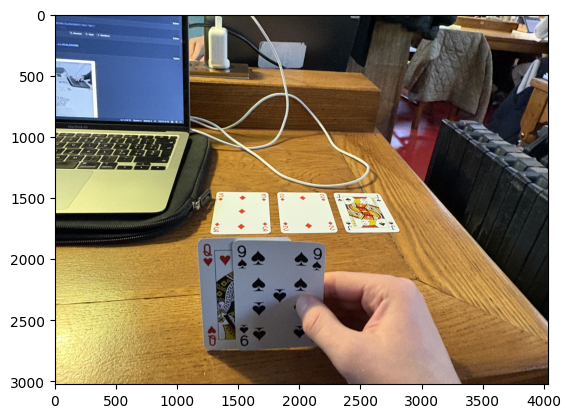

In [2]:
image_path = "../IMG_0030.jpeg"

image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [3]:
def rgb2gray(img):
    gray = img.copy()
    gray[:, :, 0] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 1] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    gray[:, :, 2] = .299 * img[:, :, 0] + .587 * img[:, :, 1] + .114 * img[:, :, 2]
    return gray

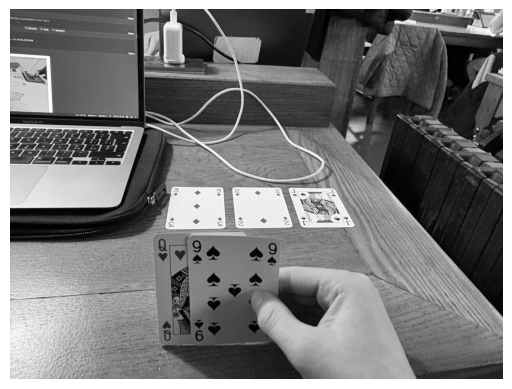

In [4]:
gray = rgb2gray(image)
plt.imshow(gray)
plt.axis('off')
plt.show()

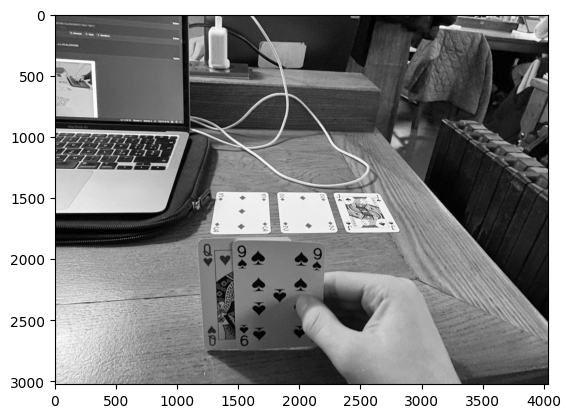

In [5]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plt.imshow(blurred)

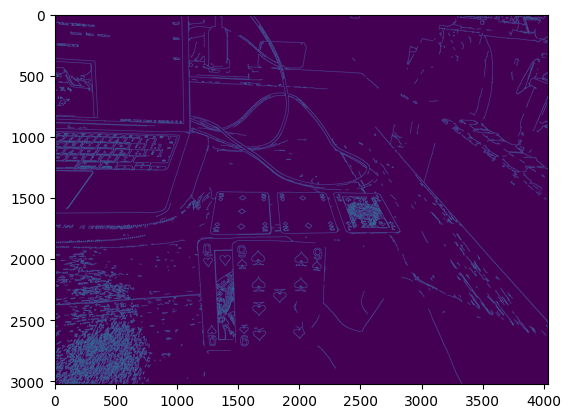

In [6]:
edges = cv2.Canny(blurred, 50, 150)
plt.imshow(edges)

In [7]:
from matplotlib.animation import FuncAnimation

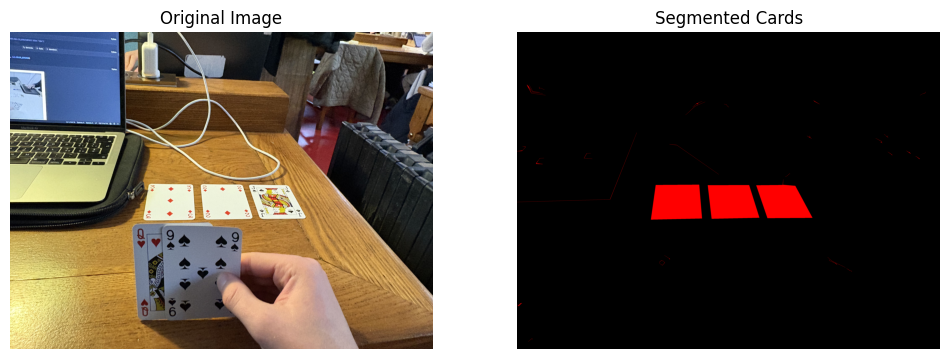

In [8]:
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros_like(gray)
A_list = []
for contour in contours:

    epsilon = 0.02 * cv2.arcLength(contour, True)
    poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

    if 4 <= len(poly) <= 8: # Becuase of approximation we check if the polygon has a number of polygons between 4 and 8
        x, y, w, h = cv2.boundingRect(poly) 
        aspect_ratio = w / float(h)
        A = w * h

        if A >= 1000 and 1.3 <= aspect_ratio <= 1.8:
            cv2.drawContours(mask, [poly], -1, 255, -1) 


plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Segmented Mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Segmented Cards")
plt.axis('off')

plt.show()


In [9]:
path_name = '../shared_data/kaggle_playing_card_ataset/Images/Images/'

In [10]:
img_paths = []
for filename in os.listdir(path_name):
    if filename.endswith(".jpg"):
        img_path = path_name + filename
        img_paths.append(img_path)

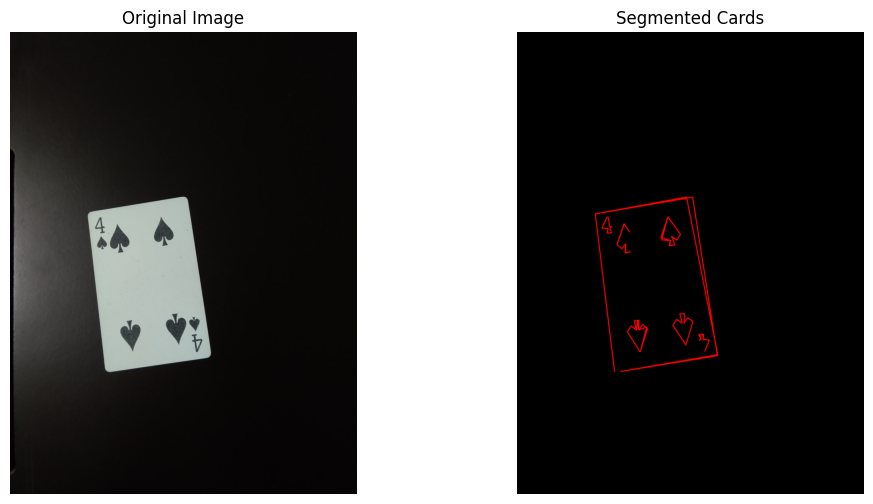

In [13]:
def segment_cards(image_path:str, plot:bool=True) -> np.array:

    img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros_like(gray)
    warped_cards = []
    for contour in contours:

        epsilon = 0.02 * cv2.arcLength(contour, True)
        poly = cv2.approxPolyDP(contour, epsilon, True) # Approximate a polygon based on the contour

        if 4 <= len(poly):
            _, _, w, h = cv2.boundingRect(poly) 
            aspect_ratio = w / float(h)
            if w * h < 15000: continue

            # if 1 <= aspect_ratio <= 1.8 and 0.8 <= extent <= 1.0:
            cv2.drawContours(mask, [poly], -1, 255, 10) 
            pts = np.array([poly[i][0] for i in range(4)], dtype="float32")
            dst = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype="float32")
            M = cv2.getPerspectiveTransform(pts, dst)
            warped = cv2.warpPerspective(img, M, (w, h))
            warped_cards.append(warped)

    if plot:
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Segmented Mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Segmented Cards")
        plt.axis('off')

        plt.show()
    
    return mask

for path in img_paths[:1]:
    _ = segment_cards(path)

# Secondo tentativo

In [1]:
from ultralytics import YOLO
import torch

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'
device

device(type='mps')